In [1]:
pip install --upgrade pyspark

Requirement already up-to-date: pyspark in c:\users\juan7\anaconda3\lib\site-packages (3.2.0)
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


In [3]:
runways=pd.read_csv('DATASETS/runways.csv')
airports=pd.read_csv('DATASETS/airports.csv')
vuelos=pd.read_csv('DATASETS/vuelosEtapa3.csv')
aeropuertos=pd.read_csv('DATASETS/aeropuertosEtapa3.csv')
aircraft=pd.read_excel('DATASETS/AircraftTypes.xlsx')

In [4]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/share/java/mariadb-java-client-2.5.3.jar pyspark-shell'

In [5]:
airports.head(5)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR


In [6]:
airports.columns

Index(['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'continent', 'iso_country', 'iso_region',
       'municipality', 'scheduled_service', 'gps_code', 'iata_code',
       'local_code', 'home_link', 'wikipedia_link', 'keywords'],
      dtype='object')

In [7]:
airports.dtypes

id                     int64
ident                 object
type                  object
name                  object
latitude_deg         float64
longitude_deg        float64
elevation_ft         float64
continent             object
iso_country           object
iso_region            object
municipality          object
scheduled_service     object
gps_code              object
iata_code             object
local_code            object
home_link             object
wikipedia_link        object
keywords              object
dtype: object

In [8]:
runways.head(5)

,id,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,269408,6523,00A,80.0,80.0,ASPH-G,1,0,H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,255155,6524,00AK,2500.0,70.0,GRVL,0,0,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
2,254165,6525,00AL,2300.0,200.0,TURF,0,0,01,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
3,270932,6526,00AR,40.0,40.0,GRASS,0,0,H1,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN
4,322128,322127,00AS,1450.0,60.0,Turf,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN


In [9]:
runways.dtypes

id                             int64
airport_ref                    int64
airport_ident                 object
length_ft                    float64
width_ft                     float64
surface                       object
lighted                        int64
closed                         int64
le_ident                      object
le_latitude_deg              float64
le_longitude_deg             float64
le_elevation_ft              float64
le_heading_degT              float64
le_displaced_threshold_ft    float64
he_ident                      object
he_latitude_deg              float64
he_longitude_deg             float64
he_elevation_ft              float64
he_heading_degT              float64
he_displaced_threshold_ft    float64
dtype: object

In [10]:
vuelos.head(5)

,ano,mes,origen,destino,tipo_equipo,tipo_vuelo,trafico,empresa,vuelos,sillas,carga_ofrecida,pasajeros,carga_bordo
0,2016,11,BOG,MDE,R722,R,N,LAS,3,0,72000.0,0,60146.0
1,2014,2,EOH,BGA,JS32,R,N,AEROLINEA DE ANTIOQUIA S.A.,45,766,112220.0,439,999.0
2,2017,4,VDF,EOH,C210,T,N,HELI JET SAS,15,0,0.0,60,0.0
3,2018,12,PEI,EOH,C303,T,N,HELI JET SAS,4,0,0.0,3,0.0
4,2018,12,LMC,BOG,JS32,T,N,SARPA S.A.S,2,0,0.0,3,0.0


In [11]:
vuelos.dtypes

ano                 int64
mes                 int64
origen             object
destino            object
tipo_equipo        object
tipo_vuelo         object
trafico            object
empresa            object
vuelos              int64
sillas              int64
carga_ofrecida    float64
pasajeros           int64
carga_bordo       float64
dtype: object

In [12]:
aeropuertos.head(5)

,sigla,iata,nombre,municipio,departamento,categoria,latitud,longitud,propietario,explotador,...,elevacion,resolucion,fecha_construccion,fecha_vigencia,clase,tipo,numero_vuelos_origen,gcd_departamento,gcd_municipio,Ano
0,7FO,NaN,LA ISLA,Puerto Gaitán,Meta,Aeródromo,4.4211,-71.6271,LA ISLA Y EL ROSARIO S.A.,LA CEIBA S.A.,...,538.0,"1325,000",2015-06-05,2018-06-11,1A,Fumigación,2.0,50,50568,2015
1,7FO,NaN,LA ISLA,Puerto Gaitán,Meta,Aeródromo,4.4211,-71.6271,LA ISLA Y EL ROSARIO S.A.,LA CEIBA S.A.,...,538.0,"1325,000",2015-06-05,2018-06-11,1A,Fumigación,2.0,50,50568,2016
2,7FU,NaN,LA ESCONDIDA,Puerto Gaitán,Meta,Aeródromo,4.6108,-71.1935,PALMAS SICARARE S.A.S.,COSARGO S.A.S.,...,564.0,"1843,000",2013-04-26,2016-05-07,1A,Aerocivil,24.0,50,50568,2014
3,7FU,NaN,LA ESCONDIDA,Puerto Gaitán,Meta,Aeródromo,4.6108,-71.1935,PALMAS SICARARE S.A.S.,COSARGO S.A.S.,...,564.0,"1843,000",2013-04-26,2016-05-07,1A,Aerocivil,24.0,50,50568,2015
4,7FU,NaN,LA ESCONDIDA,Puerto Gaitán,Meta,Aeródromo,4.6108,-71.1935,PALMAS SICARARE S.A.S.,COSARGO S.A.S.,...,564.0,"1843,000",2013-04-26,2016-05-07,1A,Público,12.0,50,50568,2016


In [13]:
aeropuertos.dtypes

sigla                    object
iata                     object
nombre                   object
municipio                object
departamento             object
categoria                object
latitud                 float64
longitud                float64
propietario              object
explotador               object
longitud_pista          float64
ancho_pista             float64
pbmo                    float64
elevacion               float64
resolucion               object
fecha_construccion       object
fecha_vigencia           object
clase                    object
tipo                     object
numero_vuelos_origen    float64
gcd_departamento          int64
gcd_municipio             int64
Ano                       int64
dtype: object

In [14]:
aircraft.head(5)

,AircraftDescription,Description,Designator,EngineCount,EngineType,ManufacturerCode,ModelFullName,WTC
0,LandPlane,L2J,J328,2,Jet,328 SUPPORT SERVICES,Dornier 328JET,M
1,LandPlane,L1P,UL45,1,Piston,3XTRIM,450 Ultra,L
2,LandPlane,L1P,UL45,1,Piston,3XTRIM,Ultra,L
3,LandPlane,L1P,TR55,1,Piston,3XTRIM,550 Trener,L
4,LandPlane,L1P,TR55,1,Piston,3XTRIM,Trener,L


In [15]:
aircraft.dtypes

AircraftDescription    object
Description            object
Designator             object
EngineCount            object
EngineType             object
ManufacturerCode       object
ModelFullName          object
WTC                    object
dtype: object

In [16]:
# Estacio para funciones

# Funcion para explorar las caracteristicas de los DataFrames
def describe_exploration(df):
    
    s=df.shape
    t=df.dtypes
    d=df.describe()
    d_o=df.describe(include='object')
    
    return s, t, d, d_o

#Exploracion de la informacion de las columnas
def columns_exploration(df,column_name):
    print(df[column_name].value_counts())
    

# Funcion para explorar de los valores nulos
def null_exploration(df):
    
    print(df.isnull().sum())
    print(df.isnull().mean())

# Cambio de los valores nulos
def null_imputation(df,column_name):
    df[column_name].fillna(df[column_name].mean(), inplace=True)
    
    return df

def hist_graph(df, column_names):
    for column_name in column_names:

        df[column_name].hist(bins=30, figsize=(15,7), density=True, histtype='step',linewidth=2)
        plt.xticks(rotation='vertical')

        plt.title(column_name)
        plt.show()


def hori_boxplot(x,y, data):
    sns.set_theme(style="ticks")

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=(10,20))
    ax.set_xscale("log")

    # dataset
    data

    # Plot the orbital period with horizontal boxes
    sns.boxplot(x=x, y=y, data=data,
                whis=[0, 100], width=.4, orient="h",palette="Set3")

    # Add in points to show each observation
    sns.stripplot(x=x, y=y, data=data,
                  size=3, color=".3", linewidth=0)

    # Tweak the visual presentation
    ax.xaxis.grid(True)
    ax.set(ylabel="")
    sns.despine(trim=True, left=True)
    return plt.show()

def groupby_2_cols_against_target(df, column1, column2, target):

    groupby_2_cols_against_target = df.groupby(
        [column1, column2]
    )[target].sum() / df.groupby(
        [column1, column2]
    )[target].count() * 100.0

    pivot_t = groupby_2_cols_against_target.reset_index().pivot(
        index=column1,
        columns=column2,
        values=target
    )
    
    return pivot_t


def groupby_var_target(df, column_name, target_name, title):
    ## group by
    groupby_var_target = df.groupby(
        column_name
    )[target_name].sum() / df.groupby(
        column_name
    )[target_name].count() * 100.0
    
    ## plot groupby
    ax = groupby_var_target.sort_values(ascending=False).plot(
        kind='bar',
        color='skyblue',
        grid=True,
        figsize=(10, 7),
        title=title
    )

def groupby_var_percent(df, column_name, target_name, title):
    ## group by
    groupby_var_target = df.groupby(
        column_name
    )[target_name].sum() / df.groupby(
        column_name
    )[target_name].count() 
    
    ## plot groupby
    ax = groupby_var_target.sort_values(ascending=False).plot(
        kind='bar',
        color='skyblue',
        grid=True,
        figsize=(10, 7),
        title=title
    )
    
    return groupby_var_target, plt.show()



In [17]:
# Exploracion de la informacion de los DataFrames disponibles
list_df=[runways, airports, vuelos, aeropuertos, aircraft]
for i in list_df:
    s, t, d, d_o=describe_exploration(i)
    print(f'A continuacion los datos del DataSet La dimension es: {s}')
    print(f'El tipo de datos: {t}')
    print(f'El resumen de la informacion estadistica de valores numericos: {d}')
    print(f'El resumen de la informacion estadistica tipo str: {d_o}')

A continuacion los datos del DataSet La dimension es: (42895, 20)
El tipo de datos: id                             int64
airport_ref                    int64
airport_ident                 object
length_ft                    float64
width_ft                     float64
surface                       object
lighted                        int64
closed                         int64
le_ident                      object
le_latitude_deg              float64
le_longitude_deg             float64
le_elevation_ft              float64
le_heading_degT              float64
le_displaced_threshold_ft    float64
he_ident                      object
he_latitude_deg              float64
he_longitude_deg             float64
he_elevation_ft              float64
he_heading_degT              float64
he_displaced_threshold_ft    float64
dtype: object
El resumen de la informacion estadistica de valores numericos:                   id    airport_ref      length_ft      width_ft  \
count   42895.000000   42895.00

In [18]:
# Analisis

# En el año donde se reañozaron mas viaj esfue en el 2013, especificamente ene el mes 12, en los que 
# la cantidad de pasajeros y de carga fue muy superior, teniendo como valor maximo de pasajerso transportado
#duarante un periodo un total de 65195

In [19]:
# Evaluando las columnas de cada Dataset 
for j in list_df:
    for i in j:
        columns_exploration(j,i)

264191    1
234872    1
255350    1
261493    1
259444    1
         ..
342674    1
270993    1
250511    1
318094    1
262144    1
Name: id, Length: 42895, dtype: int64
300162    10
3754      10
18256      9
8413       8
24720      8
          ..
302215     1
322697     1
335223     1
9360       1
2049       1
Name: airport_ref, Length: 36275, dtype: int64
KORD    10
KNHU    10
JRA      9
TA12     8
1LA9     8
        ..
1NY7     1
FL06     1
5OH3     1
KXNA     1
5Z4      1
Name: airport_ident, Length: 36275, dtype: int64
2000.0    989
40.0      917
50.0      854
3000.0    853
2500.0    687
         ... 
3187.0      1
2162.0      1
9765.0      1
6665.0      1
4813.0      1
Name: length_ft, Length: 5511, dtype: int64
100.0    4515
75.0     3919
50.0     3189
98.0     2774
60.0     2769
         ... 
430.0       1
999.0       1
323.0       1
228.0       1
199.0       1
Name: width_ft, Length: 330, dtype: int64
ASP              10964
TURF              7488
CONC              3080
CON    

BOG    21756
VVC     7339
EYP     5172
CLO     5154
BAQ     3940
       ...  
GER        1
AGU        1
MRA        1
PLD        1
7FO        1
Name: origen, Length: 484, dtype: int64
BOG    21910
VVC     7130
EYP     5200
CLO     5017
BAQ     3857
       ...  
MUZ        1
SNP        1
MPN        1
UMB        1
PRI        1
Name: destino, Length: 481, dtype: int64
B190    7629
PA34    7583
C206    6402
A320    5442
C172    4574
        ... 
RJ85       1
PA24       1
B77        1
PA36       1
A58        1
Name: tipo_equipo, Length: 140, dtype: int64
T    58392
R    35210
A     1577
C     1167
Name: tipo_vuelo, dtype: int64
N    93226
I     3120
Name: trafico, dtype: int64
AVIANCA                                           11633
SEARCA S.A.                                        9364
SERVICIO AEREO A TERRITORIOS NACIONALES SATENA     8329
SAER                                               5887
AIRES                                              3632
                                        

In [20]:
#Verificando los valores nulos y su cantidad
for j in list_df:
    null_exploration(j)    

id                               0
airport_ref                      0
airport_ident                    0
length_ft                      202
width_ft                      2749
surface                        379
lighted                          0
closed                           0
le_ident                       128
le_latitude_deg              28137
le_longitude_deg             28145
le_elevation_ft              30343
le_heading_degT              28465
le_displaced_threshold_ft    40042
he_ident                      6389
he_latitude_deg              28173
he_longitude_deg             28171
he_elevation_ft              30489
he_heading_degT              26657
he_displaced_threshold_ft    39736
dtype: int64
id                           0.000000
airport_ref                  0.000000
airport_ident                0.000000
length_ft                    0.004709
width_ft                     0.064087
surface                      0.008836
lighted                      0.000000
closed               

In [21]:
# [runways, airports, vuelos, aeropuertos, aircraft]

runways1=runways.fillna(0)
airports1=airports.fillna(0)
vuelos1=vuelos.fillna(0)
aeropuertos1=aeropuertos.fillna(0)
aircraft1=aircraft.fillna(0)

In [22]:
list_df1=[runways1, airports1, vuelos1, aeropuertos1, aircraft1]
for j in list_df1:
    null_exploration(j)  

id                           0
airport_ref                  0
airport_ident                0
length_ft                    0
width_ft                     0
surface                      0
lighted                      0
closed                       0
le_ident                     0
le_latitude_deg              0
le_longitude_deg             0
le_elevation_ft              0
le_heading_degT              0
le_displaced_threshold_ft    0
he_ident                     0
he_latitude_deg              0
he_longitude_deg             0
he_elevation_ft              0
he_heading_degT              0
he_displaced_threshold_ft    0
dtype: int64
id                           0.0
airport_ref                  0.0
airport_ident                0.0
length_ft                    0.0
width_ft                     0.0
surface                      0.0
lighted                      0.0
closed                       0.0
le_ident                     0.0
le_latitude_deg              0.0
le_longitude_deg             0.0
le_e

In [23]:
vuelos_int=vuelos1[(vuelos1['trafico']=='I')]
vuelos_nal=vuelos1[(vuelos1['trafico']=='N')]

In [24]:
origen_nal=vuelos_nal['origen'].unique().tolist()
destino_nal=vuelos_nal['destino'].unique().tolist()

In [25]:
len(origen_nal)


382

In [26]:
origen_int=vuelos_int['origen'].unique().tolist()
destino_int=vuelos_int['destino'].unique().tolist()


In [27]:
international=origen_int+destino_int
len(international)

252

In [28]:
airports1=airports.drop(['id','scheduled_service','gps_code'
               ,'local_code','home_link','wikipedia_link','keywords','iso_country'],axis=1)


In [29]:
null_exploration(airports1)

ident                0
type                 0
name                 0
latitude_deg         0
longitude_deg        0
elevation_ft     13081
continent        34010
iso_region           0
municipality      5385
iata_code        59831
dtype: int64
ident            0.000000
type             0.000000
name             0.000000
latitude_deg     0.000000
longitude_deg    0.000000
elevation_ft     0.189407
continent        0.492449
iso_region       0.000000
municipality     0.077972
iata_code        0.866325
dtype: float64


In [30]:
null_imputation(airports1,['elevation_ft'])

C:\Users\juan7\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_region,municipality,iata_code
0,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US-PA,Bensalem,NaN
1,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US-KS,Leoti,NaN
2,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US-AK,Anchor Point,NaN
3,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US-AL,Harvest,NaN
4,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US-AR,Newport,NaN
...,...,...,...,...,...,...,...,...,...,...
69058,ZZ-0001,heliport,Sealand Helipad,51.894444,1.482500,40.0,EU,GB-ENG,Sealand,NaN
69059,ZZ-0002,small_airport,Glorioso Islands Airstrip,-11.584278,47.296389,11.0,AF,TF-U-A,Grande Glorieuse,NaN
69060,ZZ-0003,small_airport,Fainting Goat Airport,32.110587,-97.356312,690.0,NaN,US-TX,Blum,NaN
69061,ZZZW,closed,Scandium City Heliport,69.355287,-138.939310,4.0,NaN,CA-YT,(Old) Scandium City,ZYW


In [31]:
airports1=airports1.dropna()
airports1

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_region,municipality,iata_code
229,03N,small_airport,Utirik Airport,11.222000,169.852005,4.0,OC,MH-UTI,Utirik Island,UTK
10766,AAD,small_airport,Adado Airport,6.095802,46.637500,1001.0,AF,SO-GA,Adado,AAD
10770,ABP,small_airport,Atkamba Airport,-6.064620,141.095173,150.0,OC,PG-WPD,Atkamba Mission,ABP
10771,ABW,closed,Abau Airport,-10.195600,148.738900,10.0,OC,PG-CPM,Abau,ABW
10772,ACFC,small_airport,Woodland Airpark (duplicate),15.253888,120.677222,100.0,AS,PH-PAM,Magalang,WAP
...,...,...,...,...,...,...,...,...,...,...
69049,ZYSQ,medium_airport,Songyuan Chaganhu Airport,44.938114,124.550178,459.0,AS,CN-22,Qian Gorlos Mongol Autonomous County,YSQ
69051,ZYTL,large_airport,Dalian Zhoushuizi International Airport,38.965698,121.539001,107.0,AS,CN-21,"Ganjingzi, Dalian",DLC
69052,ZYTN,medium_airport,Tonghua Sanyuanpu Airport,42.253889,125.703333,1200.0,AS,CN-22,Tonghua,TNH
69053,ZYTX,large_airport,Shenyang Taoxian International Airport,41.639801,123.483002,198.0,AS,CN-21,"Hunnan, Shenyang",SHE


In [32]:
null_exploration(airports1)

ident            0
type             0
name             0
latitude_deg     0
longitude_deg    0
elevation_ft     0
continent        0
iso_region       0
municipality     0
iata_code        0
dtype: int64
ident            0.0
type             0.0
name             0.0
latitude_deg     0.0
longitude_deg    0.0
elevation_ft     0.0
continent        0.0
iso_region       0.0
municipality     0.0
iata_code        0.0
dtype: float64


In [33]:
runways.shape

(42895, 20)

In [34]:
null_exploration(runways)

id                               0
airport_ref                      0
airport_ident                    0
length_ft                      202
width_ft                      2749
surface                        379
lighted                          0
closed                           0
le_ident                       128
le_latitude_deg              28137
le_longitude_deg             28145
le_elevation_ft              30343
le_heading_degT              28465
le_displaced_threshold_ft    40042
he_ident                      6389
he_latitude_deg              28173
he_longitude_deg             28171
he_elevation_ft              30489
he_heading_degT              26657
he_displaced_threshold_ft    39736
dtype: int64
id                           0.000000
airport_ref                  0.000000
airport_ident                0.000000
length_ft                    0.004709
width_ft                     0.064087
surface                      0.008836
lighted                      0.000000
closed               

In [35]:
runways.columns.tolist()

['id',
 'airport_ref',
 'airport_ident',
 'length_ft',
 'width_ft',
 'surface',
 'lighted',
 'closed',
 'le_ident',
 'le_latitude_deg',
 'le_longitude_deg',
 'le_elevation_ft',
 'le_heading_degT',
 'le_displaced_threshold_ft',
 'he_ident',
 'he_latitude_deg',
 'he_longitude_deg',
 'he_elevation_ft',
 'he_heading_degT',
 'he_displaced_threshold_ft']

In [36]:
runways=runways.drop( ['id','surface','le_ident',
 'le_latitude_deg',
 'le_longitude_deg',
 'le_elevation_ft',
 'le_heading_degT',
 'le_displaced_threshold_ft',
 'he_ident',
 'he_latitude_deg',
 'he_longitude_deg',
 'he_elevation_ft',
 'he_heading_degT',
 'he_displaced_threshold_ft'], axis=1)

In [37]:
null=['width_ft','length_ft']
for i in null:
    null_imputation(runways,i)

In [38]:
null_exploration(runways)

airport_ref      0
airport_ident    0
length_ft        0
width_ft         0
lighted          0
closed           0
dtype: int64
airport_ref      0.0
airport_ident    0.0
length_ft        0.0
width_ft         0.0
lighted          0.0
closed           0.0
dtype: float64


In [39]:
runways.to_csv("DATASETS/pistas_int.csv", index=False)
airports1.to_csv("DATASETS/airports_int.csv", index=False)

In [40]:
air_int=airports1.join(runways, how='left')

In [41]:
air_int=air_int.fillna(0)

In [42]:
null_exploration(air_int)

ident            0
type             0
name             0
latitude_deg     0
longitude_deg    0
elevation_ft     0
continent        0
iso_region       0
municipality     0
iata_code        0
airport_ref      0
airport_ident    0
length_ft        0
width_ft         0
lighted          0
closed           0
dtype: int64
ident            0.0
type             0.0
name             0.0
latitude_deg     0.0
longitude_deg    0.0
elevation_ft     0.0
continent        0.0
iso_region       0.0
municipality     0.0
iata_code        0.0
airport_ref      0.0
airport_ident    0.0
length_ft        0.0
width_ft         0.0
lighted          0.0
closed           0.0
dtype: float64


In [43]:
    s, t, d, d_o=describe_exploration(air_int)
    print(f'A continuacion los datos del DataSet La dimension es: {s}')
    print(f'El tipo de datos: {t}')
    print(f'El resumen de la informacion estadistica de valores numericos: {d}')
    print(f'El resumen de la informacion estadistica tipo str: {d_o}')

A continuacion los datos del DataSet La dimension es: (5443, 16)
El tipo de datos: ident             object
type              object
name              object
latitude_deg     float64
longitude_deg    float64
elevation_ft     float64
continent         object
iso_region        object
municipality      object
iata_code         object
airport_ref      float64
airport_ident     object
length_ft        float64
width_ft         float64
lighted          float64
closed           float64
dtype: object
El resumen de la informacion estadistica de valores numericos:        latitude_deg  longitude_deg  elevation_ft    airport_ref     length_ft  \
count   5443.000000    5443.000000   5443.000000    5443.000000   5443.000000   
mean      12.268559      42.367942   1213.915304   19689.037847   1875.723315   
std       28.441274      74.077799   1821.759623   62521.220475   2779.676199   
min      -71.957140    -179.876999  -1266.000000       0.000000      0.000000   
25%       -9.010449      -1.816555 

In [44]:
air_int.head(5)

,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_region,municipality,iata_code,airport_ref,airport_ident,length_ft,width_ft,lighted,closed
229,03N,small_airport,Utirik Airport,11.222000,169.852005,4.0,OC,MH-UTI,Utirik Island,UTK,6733.0,03OH,2100.0,60.0,0.0,0.0
10766,AAD,small_airport,Adado Airport,6.095802,46.637500,1001.0,AF,SO-GA,Adado,AAD,16137.0,AK45,3120.0,150.0,0.0,0.0
10770,ABP,small_airport,Atkamba Airport,-6.064620,141.095173,150.0,OC,PG-WPD,Atkamba Mission,ABP,16141.0,AK49,2200.0,45.0,0.0,0.0
10771,ABW,closed,Abau Airport,-10.195600,148.738900,10.0,OC,PG-CPM,Abau,ABW,16142.0,AK5,3500.0,500.0,0.0,0.0
10772,ACFC,small_airport,Woodland Airpark (duplicate),15.253888,120.677222,100.0,AS,PH-PAM,Magalang,WAP,16143.0,AK50,2000.0,26.0,0.0,0.0


In [45]:
air_int.columns.tolist()

['ident',
 'type',
 'name',
 'latitude_deg',
 'longitude_deg',
 'elevation_ft',
 'continent',
 'iso_region',
 'municipality',
 'iata_code',
 'airport_ref',
 'airport_ident',
 'length_ft',
 'width_ft',
 'lighted',
 'closed']

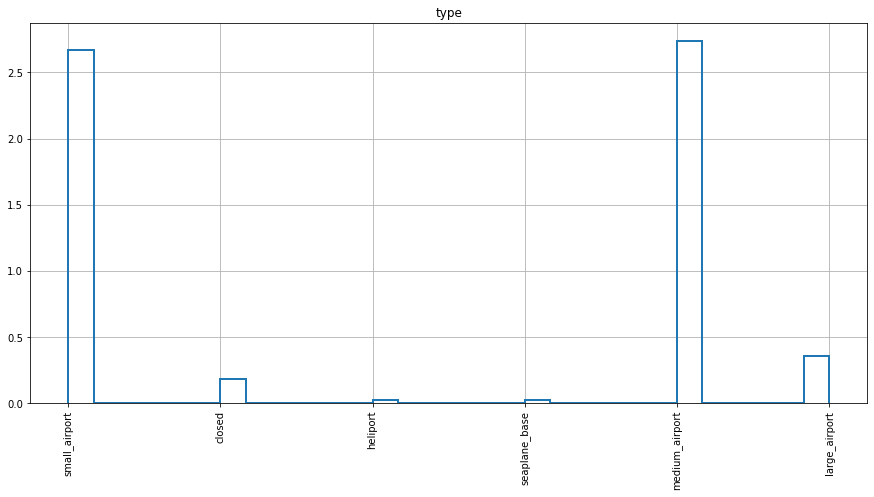

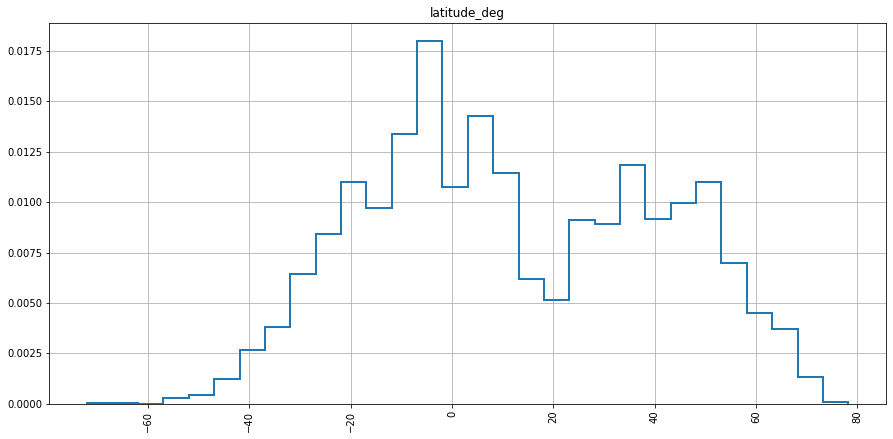

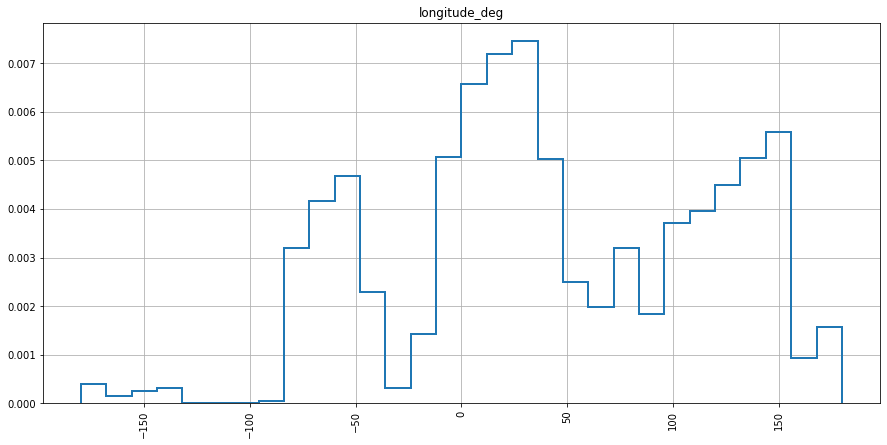

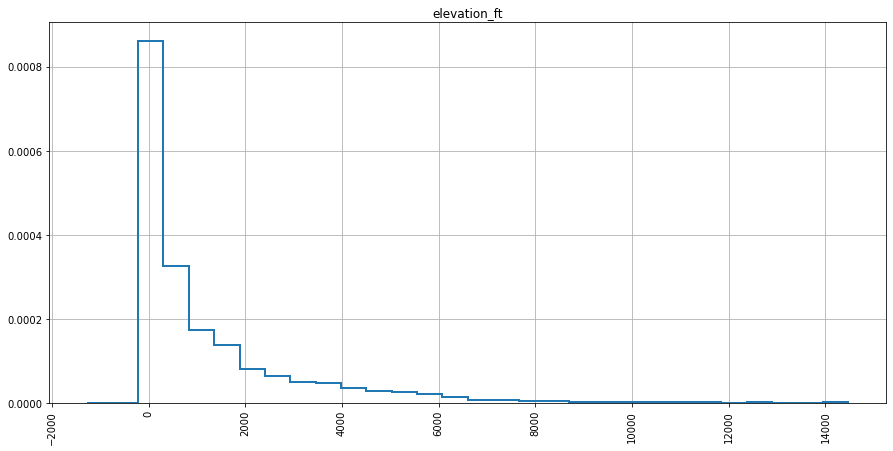

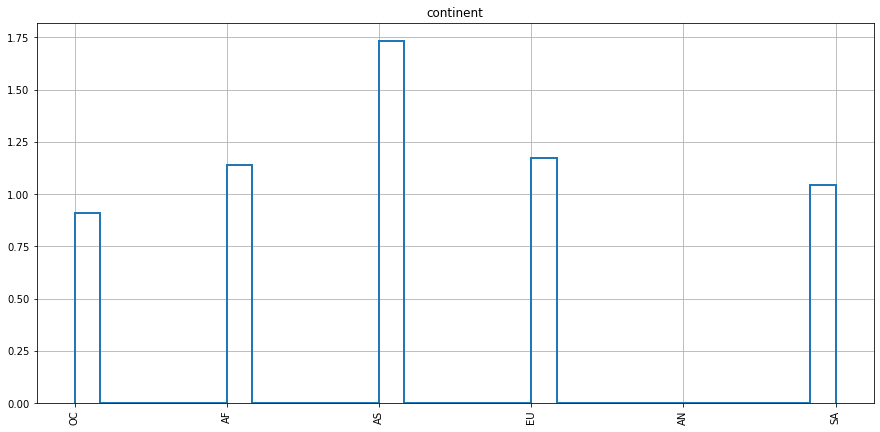

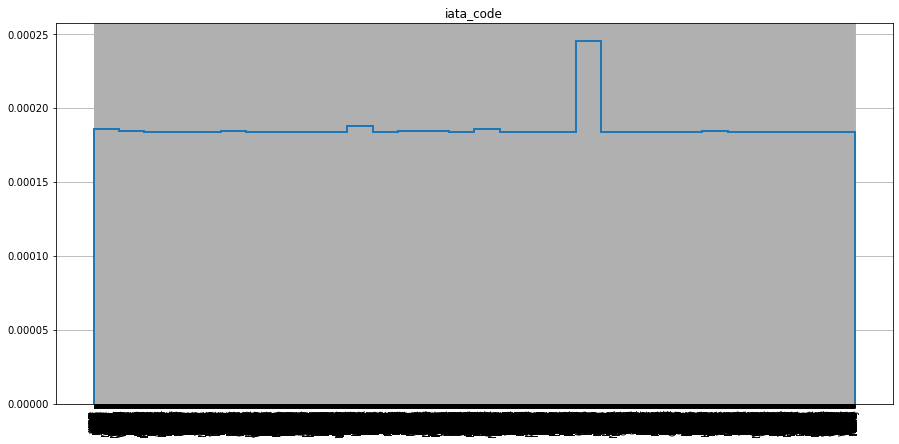

In [46]:
lista=['type', 'latitude_deg','longitude_deg','elevation_ft','continent','iata_code']
for i in lista:
    hist_graph(air_int, [i])

In [47]:
air_int.dtypes

ident             object
type              object
name              object
latitude_deg     float64
longitude_deg    float64
elevation_ft     float64
continent         object
iso_region        object
municipality      object
iata_code         object
airport_ref      float64
airport_ident     object
length_ft        float64
width_ft         float64
lighted          float64
closed           float64
dtype: object

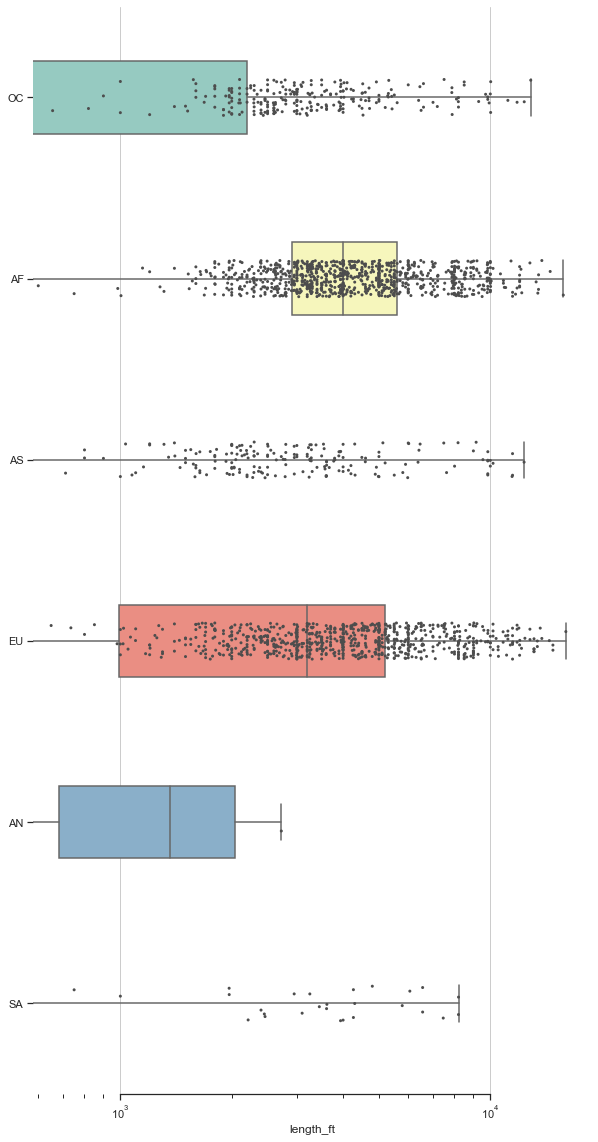

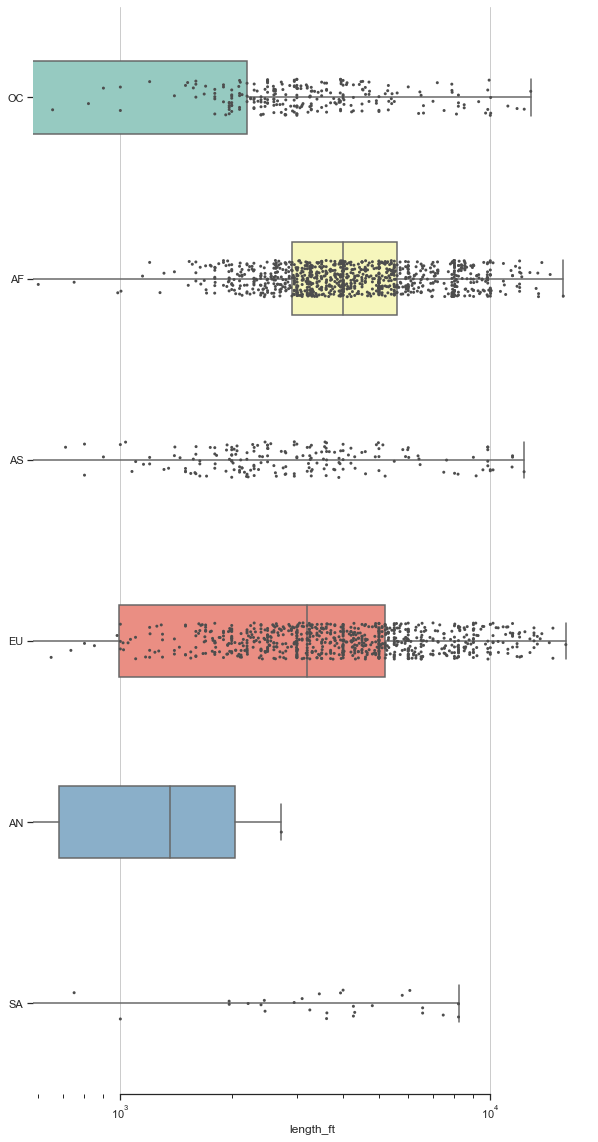

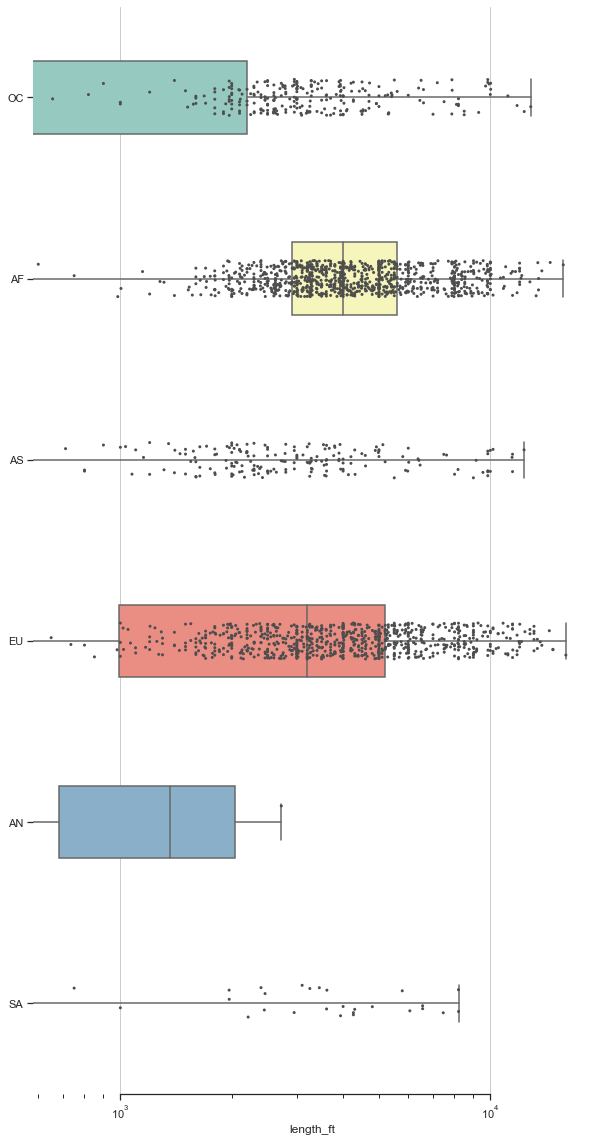

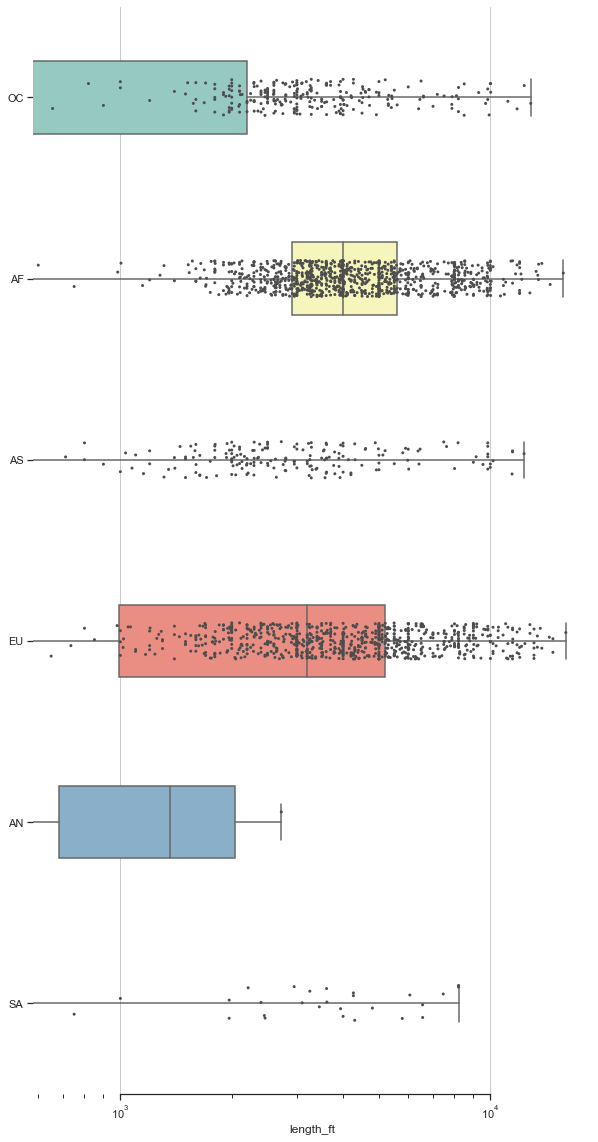

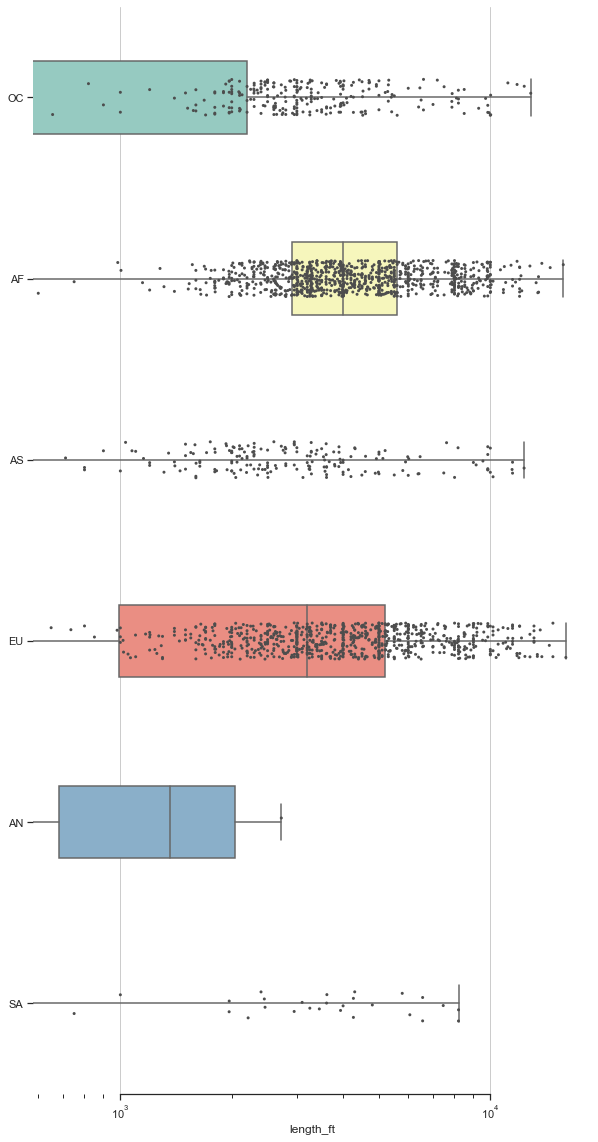

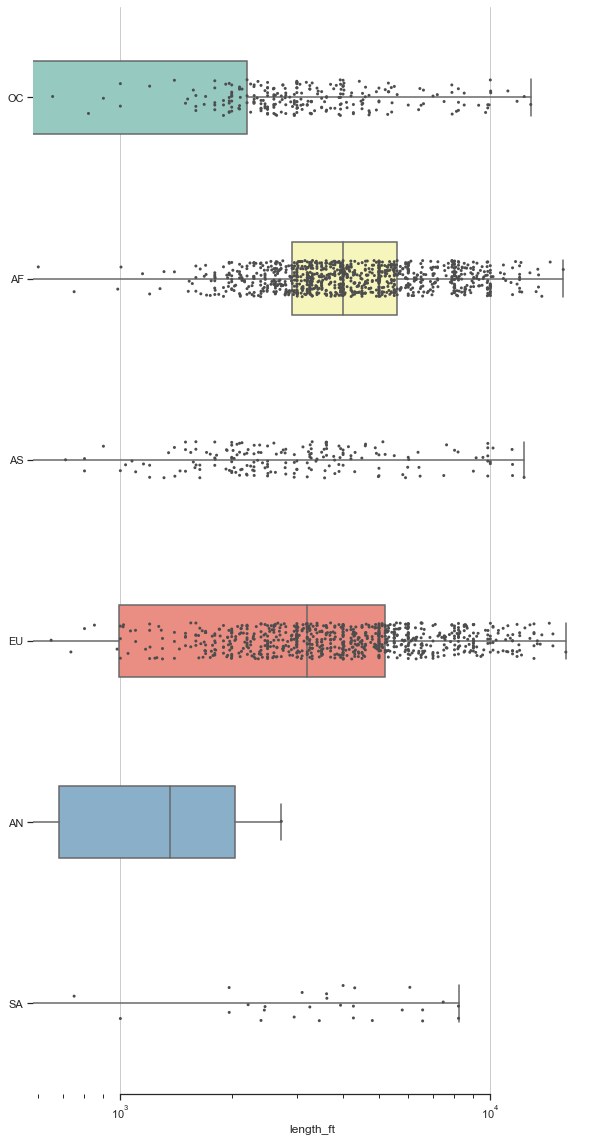

In [48]:
for i in lista:
    hori_boxplot('length_ft','continent', air_int)

In [49]:
#conversion de pies a metros
air_int['elevacion']=round(air_int['elevation_ft']*3.28084,2)
air_int['longitud_pista']=round(air_int['length_ft']*3.28084,2)
air_int['ancho_pista']=round(air_int['width_ft']*3.28084,2)

In [50]:
air_int=air_int.drop(['elevation_ft', 'width_ft', 'length_ft'], axis=1)


In [51]:
air_int

,ident,type,name,latitude_deg,longitude_deg,continent,iso_region,municipality,iata_code,airport_ref,airport_ident,lighted,closed,elevacion,longitud_pista,ancho_pista
229,03N,small_airport,Utirik Airport,11.222000,169.852005,OC,MH-UTI,Utirik Island,UTK,6733.0,03OH,0.0,0.0,13.12,6889.76,196.85
10766,AAD,small_airport,Adado Airport,6.095802,46.637500,AF,SO-GA,Adado,AAD,16137.0,AK45,0.0,0.0,3284.12,10236.22,492.13
10770,ABP,small_airport,Atkamba Airport,-6.064620,141.095173,OC,PG-WPD,Atkamba Mission,ABP,16141.0,AK49,0.0,0.0,492.13,7217.85,147.64
10771,ABW,closed,Abau Airport,-10.195600,148.738900,OC,PG-CPM,Abau,ABW,16142.0,AK5,0.0,0.0,32.81,11482.94,1640.42
10772,ACFC,small_airport,Woodland Airpark (duplicate),15.253888,120.677222,AS,PH-PAM,Magalang,WAP,16143.0,AK50,0.0,0.0,328.08,6561.68,85.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69049,ZYSQ,medium_airport,Songyuan Chaganhu Airport,44.938114,124.550178,AS,CN-22,Qian Gorlos Mongol Autonomous County,YSQ,0.0,0,0.0,0.0,1505.91,0.00,0.00
69051,ZYTL,large_airport,Dalian Zhoushuizi International Airport,38.965698,121.539001,AS,CN-21,"Ganjingzi, Dalian",DLC,0.0,0,0.0,0.0,351.05,0.00,0.00
69052,ZYTN,medium_airport,Tonghua Sanyuanpu Airport,42.253889,125.703333,AS,CN-22,Tonghua,TNH,0.0,0,0.0,0.0,3937.01,0.00,0.00
69053,ZYTX,large_airport,Shenyang Taoxian International Airport,41.639801,123.483002,AS,CN-21,"Hunnan, Shenyang",SHE,0.0,0,0.0,0.0,649.61,0.00,0.00


In [57]:
air_int.to_csv("DATASETS/aeropuertos_internacionales.csv", index=False)

In [52]:
# flights_perfilado.to_csv("DATASETS/flights_perfilado.csv", index=False)
# airports_perfilado.to_csv("DATASETS/airports_perfilado.csv", index=False)